In [1]:
import jax.numpy as np
import numpy as onp
from jax import vmap, grad, jit

import matplotlib.pyplot as plt

from nrm_analysis.misctools import mask_definitions

from bessel import bessel_j0, bessel_j1, bessel_jn

j0, j1 = bessel_j0, bessel_j1

In [2]:
mas2rad = np.pi / 180.0 / 3600.0/ 1000.0

def jinc(x):
    dummy = 2*(j1(x)/x)
    return jax.lax.select(~np.isfinite(dummy), 1., dummy)

def vis_gauss(d,u,v):
    d = mas2rad*d
    return np.exp(-(np.pi*d*np.sqrt(u**2+v**2))**2/4./np.log(2))

def vis_ud(d,u,v):
    r = np.sqrt(u**2+v**2)
    diam = d*mas2rad
    t = jinc(np.pi*diam*r)
    return t

def vis_ring(d,u,v):
    r = np.sqrt(u**2+v**2)
    diam = d*mas2rad
    t = j0(np.pi*diam*r)
    return t
    
def vis_ellipse_disk(semi_axis,ecc,theta,u,v):
    
    semi_axis = semi_axis
    thetad = np.pi*theta/180.
    u1, v1 = u*np.cos(thetad)+v*np.sin(thetad), -u*np.sin(thetad)+v*np.cos(thetad)
    u1, v1 = u1, v1*np.sqrt(1-ecc**2.)
    
    return vis_ud(0.5*semi_axis,u1,v1)

def vis_ellipse_ring(semi_axis,cosi,theta,u,v):
    
    semi_axis = semi_axis
    thetad = np.pi*theta/180.
    u1, v1 = u*np.cos(thetad)+v*np.sin(thetad), -u*np.sin(thetad)+v*np.cos(thetad)
    u1, v1 = u1, v1*cosi

    return vis_ring(0.5*semi_axis,u1,v1)

def vis_ellipse_gauss(semi_axis,thick,gausswidth,ecc,theta,u,v):
    return vis_gauss(gausswidth,u,v)*vis_ellipse_thin(semi_axis,thick,ecc,theta,u,v)

def vis_ellipse_high_contrast(semi_axis,ecc,theta,thick,con,u,v):
    l2 = 1. / (con + 1)
    l1 = 1 - l2
    
    vises = vis_ellipse_thin(semi_axis,ecc,theta,thick,u,v)
    norm = vis_ellipse_thin(semi_axis,ecc,theta,thick,np.array([1e-5]),np.array([1e-5]))
    vises = l2*(vises/norm) + l1
    return vises

def vis_star_and_ring(semi_axis,cosi,theta,con,u,v):
    l2 = 1. / (con + 1)
    l1 = 1 - l2
    
    vises = vis_ellipse_ring(semi_axis,cosi,theta,u,v)
    vises = l2*(vises) + l1
    return vises

Text(0.5, 1.0, 'Baselines')

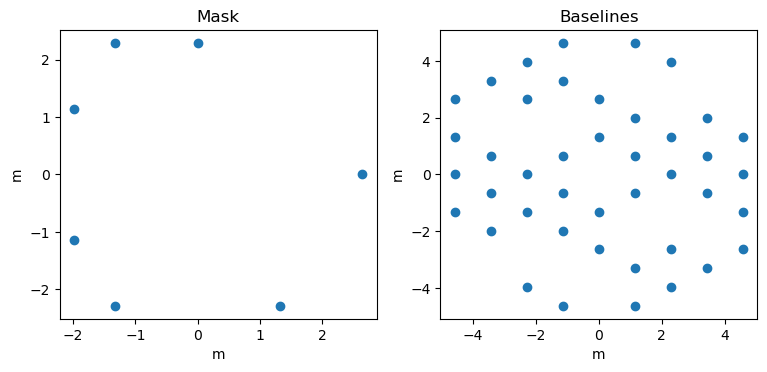

In [3]:
f2f,mask = mask_definitions.jwst_g7s6c()

thisu = onp.subtract.outer(mask[:,0],mask[:,0])
thisu = thisu.T[onp.where(~onp.eye(thisu.shape[0],dtype=bool))]

thisv = onp.subtract.outer(mask[:,1],mask[:,1])
thisv = thisv.T[onp.where(~onp.eye(thisv.shape[0],dtype=bool))]

bls = onp.array([thisv,thisu]).T
u, v = bls[:,0], bls[:,1]
args = onp.argsort(u)[:21]
u, v = u[args], v[args]
w = onp.sqrt(u**2 + v**2)

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(9.0,2.5*1.5))

ax1.scatter(mask[:,0],mask[:,1])
ax1.set_xlabel('m')
ax1.set_ylabel('m')
ax1.set_title('Mask')

ax2.scatter(bls[:,0],bls[:,1])
ax2.set_xlabel('m')
ax2.set_ylabel('m')
ax2.set_title('Baselines')


In [62]:
semi_axis = 1000 # mas
cosi = 0.5
theta = 0
wavel = 4.3e-6 # m

uu = np.abs(u).max()*onp.random.rand(100)
vv = np.abs(v).max()*onp.random.rand(100)
ww = np.sqrt(uu**2 + vv**2)
angle = np.arctan2(vv,uu)

visibilities = vis_ellipse_ring(semi_axis,cosi,theta,uu/wavel,vv/wavel)

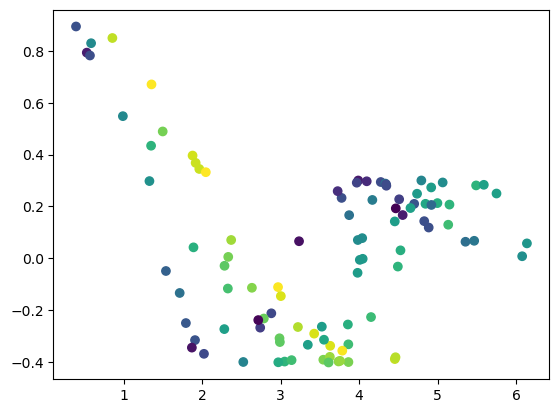

In [63]:
plt.scatter(ww, visibilities,c=angle)